TRUE TEST EVALUATION PIPELINE (Using Saved Split Indices)
Loaded dataset with 834 rows.

📑 Loading stored train/test indices...
Train size: 667
Test size : 167 (true held-out test set)

📦 Loading trained models...


✔ Models loaded successfully.

🔄 Reconstructing TF-IDF for NB...
✔ TF-IDF reconstruction complete.

🤖 Generating predictions on TRUE TEST SET...


✔ Predictions generated.

📊 TRUE TEST SET PERFORMANCE

NB           | Accuracy: 0.7006 | Macro F1: 0.4605
LR           | Accuracy: 0.9102 | Macro F1: 0.7957
RF           | Accuracy: 0.9701 | Macro F1: 0.8926
Ensemble     | Accuracy: 0.9701 | Macro F1: 0.8926

Classification Report (Ensemble):

              precision    recall  f1-score   support

    Negative       0.97      1.00      0.99        66
     Neutral       1.00      0.56      0.71         9
    Positive       0.97      0.99      0.98        92

    accuracy                           0.97       167
   macro avg       0.98      0.85      0.89       167
weighted avg       0.97      0.97      0.97       167



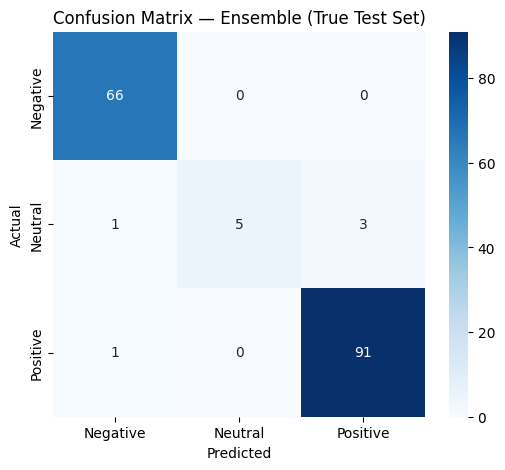

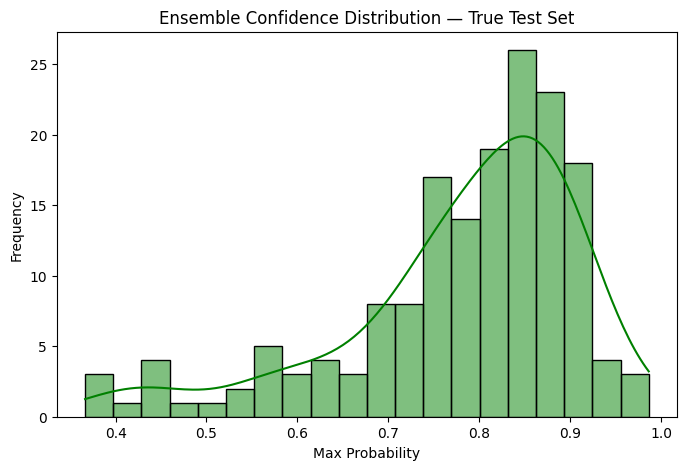


TRUE TEST EVALUATION COMPLETE — NO DATA LEAKAGE


In [1]:
import pandas as pd
import numpy as np
import pickle
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import (
    accuracy_score, f1_score,
    classification_report, confusion_matrix
)

print("="*70)
print("TRUE TEST EVALUATION PIPELINE (Using Saved Split Indices)")
print("="*70)

# ---------------------------------------------------------------
# 1) LOAD ENGINEERED FEATURES
# ---------------------------------------------------------------

df = pd.read_csv("../data/engineered_features.csv")

y_full = df["sentiment_category"].astype(str)
clean_texts = df["cleaned_text"].copy()

drop_cols = [
    "sentiment_category", "cleaned_text",
    "published_at", "dominant_emotion", "aggregate_sentiment"
]

df_num = df.drop(columns=[c for c in drop_cols if c in df.columns])
X_full = df_num.select_dtypes(include=[np.number])

print(f"Loaded dataset with {len(X_full)} rows.")

# ---------------------------------------------------------------
# 2) LOAD SAVED TRAIN/TEST SPLIT INDICES
# ---------------------------------------------------------------

print("\n📑 Loading stored train/test indices...")

indices = pickle.load(open("../models/train_test_indices.pkl", "rb"))
train_idx = indices["train_idx"]
test_idx  = indices["test_idx"]

print(f"Train size: {len(train_idx)}")
print(f"Test size : {len(test_idx)} (true held-out test set)")

# Build true Train/Test sets exactly as before
X_train = X_full.loc[train_idx]
X_test  = X_full.loc[test_idx]

y_train = y_full.loc[train_idx]
y_test  = y_full.loc[test_idx]

# For NB model: use text
clean_train = clean_texts.loc[train_idx]
clean_test  = clean_texts.loc[test_idx]

# ---------------------------------------------------------------
# 3) LOAD TRAINED MODELS & TF-IDF
# ---------------------------------------------------------------

print("\n📦 Loading trained models...")

nb_model = pickle.load(open("../models/nb_model.pkl", "rb"))
lr_model = pickle.load(open("../models/lr_model.pkl", "rb"))
rf_model = pickle.load(open("../models/rf_model.pkl", "rb"))
tfidf = pickle.load(open("../models/tfidf_vectorizer.pkl", "rb"))
classes = pickle.load(open("../models/class_labels.pkl", "rb"))

print("✔ Models loaded successfully.")

# ---------------------------------------------------------------
# 4) REBUILD TF-IDF FOR THE TRUE TEST SPLIT
# ---------------------------------------------------------------

print("\n🔄 Reconstructing TF-IDF for NB...")

X_train_tfidf = tfidf.transform(clean_train)
X_test_tfidf  = tfidf.transform(clean_test)

print("✔ TF-IDF reconstruction complete.")

# ---------------------------------------------------------------
# 5) PREDICT USING ALL MODELS
# ---------------------------------------------------------------

print("\n🤖 Generating predictions on TRUE TEST SET...")

p_nb = nb_model.predict_proba(X_test_tfidf)
p_lr = lr_model.predict_proba(X_test)
p_rf = rf_model.predict_proba(X_test)

final_prob = (p_nb + p_lr + p_rf) / 3
y_pred_ensemble = classes[np.argmax(final_prob, axis=1)]

results = {
    "NB": nb_model.predict(X_test_tfidf),
    "LR": lr_model.predict(X_test),
    "RF": rf_model.predict(X_test),
    "Ensemble": y_pred_ensemble
}

print("✔ Predictions generated.")

# ---------------------------------------------------------------
# 6) PERFORMANCE SUMMARY — TRUE HELD-OUT METRICS
# ---------------------------------------------------------------

print("\n📊 TRUE TEST SET PERFORMANCE\n")

for name, y_pred in results.items():
    print(f"{name:12s} | Accuracy: {accuracy_score(y_test, y_pred):.4f} "
          f"| Macro F1: {f1_score(y_test, y_pred, average='macro'):.4f}")

print("\nClassification Report (Ensemble):\n")
print(classification_report(y_test, y_pred_ensemble))

# ---------------------------------------------------------------
# 7) CONFUSION MATRIX
# ---------------------------------------------------------------

cm = confusion_matrix(y_test, y_pred_ensemble, labels=classes)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d",
            xticklabels=classes, yticklabels=classes)
plt.title("Confusion Matrix — Ensemble (True Test Set)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ---------------------------------------------------------------
# 8) CONFIDENCE DISTRIBUTION
# ---------------------------------------------------------------

confidence = final_prob.max(axis=1)

plt.figure(figsize=(8,5))
sns.histplot(confidence, bins=20, kde=True, color="green")
plt.title("Ensemble Confidence Distribution — True Test Set")
plt.xlabel("Max Probability")
plt.ylabel("Frequency")
plt.show()

# ---------------------------------------------------------------
# 9) DONE
# ---------------------------------------------------------------

print("\n=====================================================")
print("TRUE TEST EVALUATION COMPLETE — NO DATA LEAKAGE")
print("=====================================================")
